# Task 3: Customer Segmentation using RFM Analysis
### Internship Project – Elevvo

This project performs customer segmentation on the Online Retail dataset using **RFM (Recency, Frequency, Monetary)** analysis. 
The goal is to group customers based on purchase behavior and provide actionable insights for marketing.

## Steps:
1. Data Loading
2. Data Cleaning
3. Calculating RFM Metrics
4. Assigning RFM Scores
5. Segmentation
6. Visualizations
7. Insights & Marketing Suggestions

## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

## Step 1: Data Loading

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Step 2: Data Cleaning

In [3]:
df = df.dropna(subset=['CustomerID'])  #drops all null customerID rows
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]  #Keeps transactions with positive quantity and unit price
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']   #Creating a Column for total price

#Converting datatypes to save memory
df['CustomerID'] = df['CustomerID'].astype('int32')
df['Quantity'] = df['Quantity'].astype('int32')
df['UnitPrice'] = df['UnitPrice'].astype('float32')
df['TotalPrice'] = df['TotalPrice'].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int32         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float32       
 6   CustomerID   397884 non-null  int32         
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float32       
dtypes: datetime64[ns](1), float32(2), int32(2), object(4)
memory usage: 24.3+ MB


## Step 3: Calculate RFM Metrics

In [4]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Recency
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()
recency = (snapshot_date - last_purchase).dt.days

# Frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].count()

# Monetary
monetary = df.groupby('CustomerID')['TotalPrice'].sum()

rfm = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.601562
12347,2,182,4310.000000
12348,75,31,1797.239990
12349,19,73,1757.550049
12350,310,17,334.399994


## Step 4: Assign RFM Scores

In [5]:
# Compute the 25th, 50th, and 75th percentiles for Recency, Frequency, and Monetary
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75]).to_dict()

# Recency score: lower Recency (more recent purchase) gets higher score
def r_score(x, q):
    if x <= q['Recency'][0.25]:
        return 4
    elif x <= q['Recency'][0.50]:
        return 3
    elif x <= q['Recency'][0.75]:
        return 2
    else:
        return 1

# Frequency and Monetary score: higher values get higher score
def fm_score(x, q, col):
    if x <= q[col][0.25]:
        return 1
    elif x <= q[col][0.50]:
        return 2
    elif x <= q[col][0.75]:
        return 3
    else:
        return 4
    
#Assigning Scores to each customer
rfm['R_Score'] = rfm['Recency'].apply(lambda x: r_score(x, quantiles))
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: fm_score(x, quantiles, 'Frequency'))
rfm['M_Score'] = rfm['Monetary'].apply(lambda x: fm_score(x, quantiles, 'Monetary'))

rfm['RFM_Segment'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.601562,1,1,4,114,6
12347,2,182,4310.000000,4,4,4,444,12
12348,75,31,1797.239990,2,2,4,224,8
12349,19,73,1757.550049,3,3,4,334,10
12350,310,17,334.399994,1,1,2,112,4


## Step 5: Segementation

In [6]:
def segment_customer(rfm):
    """
    Assigns a segment label to each customer based on R, F, M scores:
    - Champions: High recency, frequency, and monetary (top customers)
    - Loyal Customers: High frequency (regular buyers)
    - At Risk: Low recency and frequency (customers who haven't purchased recently)
    - Others: All remaining customers
    """
    
    if rfm['R_Score'] >= 3 and rfm['F_Score'] >= 3 and rfm['M_Score'] >= 3:
        return 'Champions'
    elif rfm['F_Score'] >= 3:
        return 'Loyal Customers'
    elif rfm['R_Score'] <= 2 and rfm['F_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm['Segment'].value_counts()

Segment
At Risk            1484
Champions          1295
Loyal Customers     864
Others              695
Name: count, dtype: int64

## Step 6: Visualizations

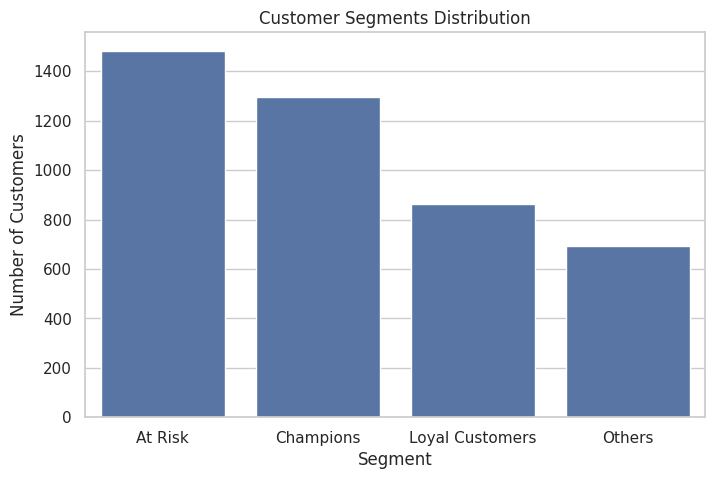

In [7]:
# Bar chart: Customer Segments Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

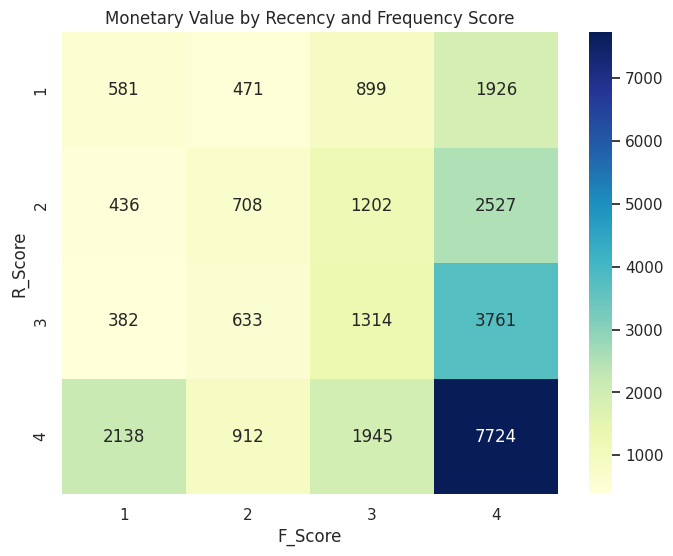

In [8]:
# Heatmap: Recency vs Frequency with Monetary
rfm_pivot = rfm.groupby(['R_Score','F_Score'])['Monetary'].mean().unstack()
plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Monetary Value by Recency and Frequency Score')
plt.show()

## Insights & Marketing Suggestions
- **Champions**: Reward loyalty, upsell products.
- **Loyal Customers**: Encourage repeat purchases, cross-sell.
- **At Risk**: Re-engagement campaigns, discounts.
- **Others**: Monitor and lightly engage.